# Facial Recog Library Test

Install Guide:
https://github.com/ageitgey/face_recognition

In [1]:
from PIL import Image, ImageDraw
import mediapipe as mp
import face_recognition
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp
import scipy.sparse as sparse
import scipy.sparse.linalg as sl
import scipy as sp
import os

In [2]:
trgt_img_path = os.path.join("..", "Images", "face_target4.jpg")
ref_img_path = os.path.join("..", "Images", "face_ref4.jpg")

In [3]:
# function to crop out added borders for plotting
def cropBorders(trgt, th, tw, rh, rw):
    if (rh > th):
        trgt = trgt[(rh-th)//2:rh-(rh-th)//2, :, :]
    if (rw > tw):
        trgt = trgt[:, (rw-tw)//2:rw-(rw-tw)//2, :]
    
    return trgt

### Facial Landmarks Detection Using MediaPipe

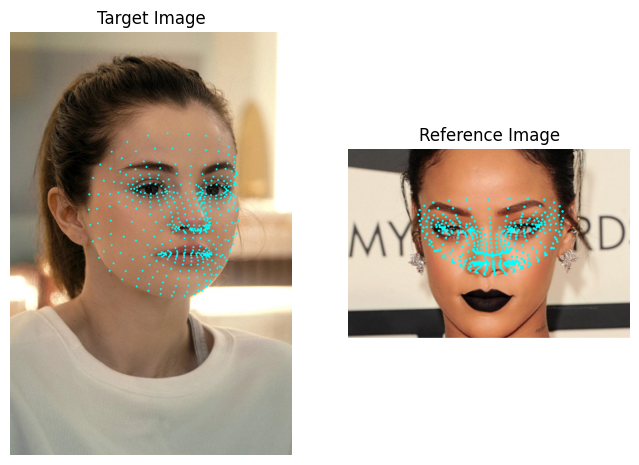

In [4]:
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)

# reduce image size if too large
trgt_img = cv2.imread(trgt_img_path)
trgt_img = cv2.cvtColor(trgt_img, cv2.COLOR_BGR2RGB)
if (trgt_img.shape[0] * trgt_img.shape[1]) > 800000:
    trgt_img = cv2.resize(trgt_img, (0, 0), fx=0.5, fy=0.5)


ref_img = cv2.imread(ref_img_path)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
if (ref_img.shape[0] * ref_img.shape[1]) > 800000:
    ref_img = cv2.resize(ref_img, (0, 0), fx=0.5, fy=0.5)

trgt_img_res = faceMesh.process(trgt_img)
ref_img_res = faceMesh.process(ref_img)

trgt_img_landmarks = []
ref_img_landmarks = []

if trgt_img_res.multi_face_landmarks:
    for face_landmarks in trgt_img_res.multi_face_landmarks:
        trgt_img_landmarks.append(face_landmarks.landmark)

if ref_img_res.multi_face_landmarks:
    for face_landmarks in ref_img_res.multi_face_landmarks:
        ref_img_landmarks.append(face_landmarks.landmark)

trgt_img_landmarks_np = np.empty((468, 2), dtype=np.float32)
ref_img_landmarks_np = np.empty((468, 2), dtype=np.float32)

for i, landmark in enumerate(trgt_img_landmarks[0]):
    trgt_img_landmarks_np[i] = np.array([landmark.x, landmark.y])

for i, landmark in enumerate(ref_img_landmarks[0]):
    ref_img_landmarks_np[i] = np.array([landmark.x, landmark.y])

trgt_img_h, trgt_img_w, _ = trgt_img.shape
ref_img_h, ref_img_w, _ = ref_img.shape

# normalize landmark locations
trgt_img_landmarks_np[:, 0] = (trgt_img_landmarks_np[:, 0] * trgt_img_w).astype(np.int32)
trgt_img_landmarks_np[:, 1] = (trgt_img_landmarks_np[:, 1] * trgt_img_h).astype(np.int32)

ref_img_landmarks_np[:, 0] = (ref_img_landmarks_np[:, 0] * ref_img_w).astype(np.int32)
ref_img_landmarks_np[:, 1] = (ref_img_landmarks_np[:, 1] * ref_img_h).astype(np.int32)

# draw landmarks over the face
pil_image1 = Image.fromarray(trgt_img)
pil_image2 = Image.fromarray(ref_img)

d1 = ImageDraw.Draw(pil_image1)
d2 = ImageDraw.Draw(pil_image2)

for point in trgt_img_landmarks_np:
    x1, y1 = point[0] - 2, point[1] - 2
    x2, y2 = point[0] + 2, point[1] + 2
    d1.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

for point in ref_img_landmarks_np:
    x1, y1 = point[0] - 2, point[1] - 2
    x2, y2 = point[0] + 2, point[1] + 2
    d2.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=1)

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(pil_image1)
plt.axis('off')
plt.title('Target Image')
plt.subplot(122)
plt.imshow(pil_image2)
plt.axis('off')
plt.title('Reference Image')
plt.show()

### Facial Landmarks Detection Using Dlib

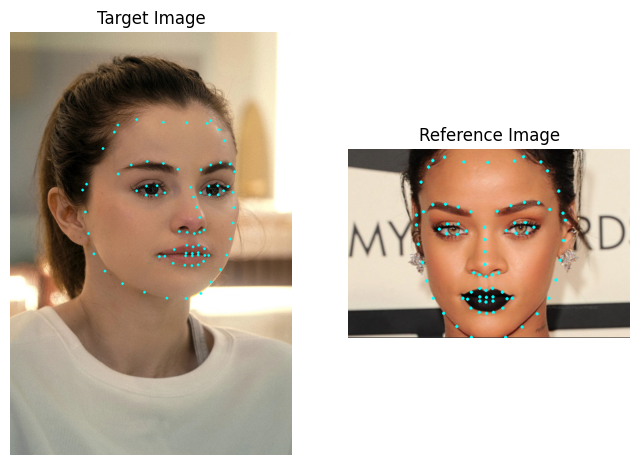

In [5]:
predictor_path = "shape_predictor_81_face_landmarks.dat"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

trgt_img = cv2.imread(trgt_img_path)
ref_img = cv2.imread(ref_img_path)

if (trgt_img.shape[0] * trgt_img.shape[1]) > 800000:
    trgt_img = cv2.resize(trgt_img, (0, 0), fx=0.5, fy=0.5)

if (ref_img.shape[0] * ref_img.shape[1]) > 800000:
    ref_img = cv2.resize(ref_img, (0, 0), fx=0.5, fy=0.5)

trgt_img = cv2.cvtColor(trgt_img, cv2.COLOR_BGR2RGB)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)

# resize the images
th, tw, _ = trgt_img.shape
rh, rw, _ = ref_img.shape

if th > rh:
    ref_img = cv2.copyMakeBorder(ref_img, (th-rh)//2, th-rh-(th-rh)//2, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
else:
    trgt_img = cv2.copyMakeBorder(trgt_img, (rh-th)//2, rh-th-(rh-th)//2, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))

if tw > rw:
    ref_img = cv2.copyMakeBorder(ref_img, 0, 0, (tw-rw)//2, tw-rw-(tw-rw)//2, cv2.BORDER_CONSTANT, value=(0,0,0))
else:
    trgt_img = cv2.copyMakeBorder(trgt_img, 0, 0, (rw-tw)//2, rw-tw-(rw-tw)//2, cv2.BORDER_CONSTANT, value=(0,0,0))
    
trgt_img_gray = cv2.cvtColor(trgt_img, cv2.COLOR_BGR2GRAY)
ref_img_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)

trgt_img_rects = detector(trgt_img, 0)
ref_img_rects = detector(ref_img, 0)

trgt_img_landmarks_np = np.empty((0,2), dtype=int)
ref_img_landmarks_np = np.empty((0,2), dtype=int)

for trgt_img_rect, ref_img_rect in zip(trgt_img_rects, ref_img_rects):
    trgt_img_shape = predictor(trgt_img_gray, trgt_img_rect)
    ref_img_shape = predictor(ref_img_gray, ref_img_rect)

    for i in range(81):
        trgt_img_landmarks_np = np.append(trgt_img_landmarks_np, [[trgt_img_shape.part(i).x, trgt_img_shape.part(i).y]], axis=0)
        ref_img_landmarks_np = np.append(ref_img_landmarks_np, [[ref_img_shape.part(i).x, ref_img_shape.part(i).y]], axis=0)

# draw landmarks over the face
pil_image1 = Image.fromarray(trgt_img)
pil_image2 = Image.fromarray(ref_img)

d1 = ImageDraw.Draw(pil_image1)
d2 = ImageDraw.Draw(pil_image2)

for point in trgt_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d1.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

for point in ref_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d2.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

pil_image1 = np.array(pil_image1)
pil_image2 = np.array(pil_image2)

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(cropBorders(pil_image1, th, tw, rh, rw))
plt.axis('off')
plt.title('Target Image')
plt.subplot(122)
plt.imshow(cropBorders(pil_image2, rh, rw, th, tw))
plt.axis('off')
plt.title('Reference Image')
plt.show()

### Facial Landmarks Detection Using Facial Recognition Library

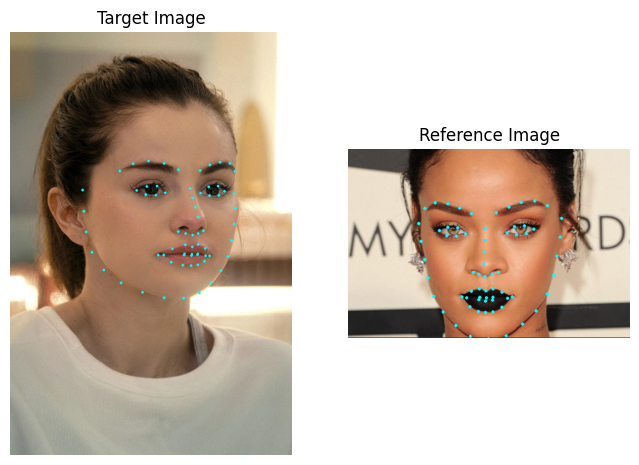

In [6]:
# get the face landmarks of both faces
trgt_img = face_recognition.load_image_file(trgt_img_path)
ref_img = face_recognition.load_image_file(ref_img_path)

if (trgt_img.shape[0] * trgt_img.shape[1]) > 800000:
    trgt_img = cv2.resize(trgt_img, (0, 0), fx=0.5, fy=0.5)

if (ref_img.shape[0] * ref_img.shape[1]) > 800000:
    ref_img = cv2.resize(ref_img, (0, 0), fx=0.5, fy=0.5)

th, tw, _ = trgt_img.shape
rh, rw, _ = ref_img.shape

# make sure that the images have the same size by adding borders
if th > rh:
    ref_img = cv2.copyMakeBorder(ref_img, (th-rh)//2, th-rh-(th-rh)//2, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
else:
    trgt_img = cv2.copyMakeBorder(trgt_img, (rh-th)//2, rh-th-(rh-th)//2, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))

if tw > rw:
    ref_img = cv2.copyMakeBorder(ref_img, 0, 0, (tw-rw)//2, tw-rw-(tw-rw)//2, cv2.BORDER_CONSTANT, value=(0,0,0))
else:
    trgt_img = cv2.copyMakeBorder(trgt_img, 0, 0, (rw-tw)//2, rw-tw-(rw-tw)//2, cv2.BORDER_CONSTANT, value=(0,0,0))

trgt_img_landmarks = face_recognition.face_landmarks(trgt_img)
ref_img_landmarks = face_recognition.face_landmarks(ref_img)

trgt_img_landmarks_np = np.empty((0,2), dtype=int)
ref_img_landmarks_np = np.empty((0,2), dtype=int)

for face_landmarks in trgt_img_landmarks:
    for facial_feature in face_landmarks.keys():
        trgt_img_landmarks_np = np.append(trgt_img_landmarks_np, face_landmarks[facial_feature], axis=0)

for face_landmarks in ref_img_landmarks:
    for facial_feature in face_landmarks.keys():
        ref_img_landmarks_np = np.append(ref_img_landmarks_np, face_landmarks[facial_feature], axis=0)

# draw landmarks over the face
pil_image1 = Image.fromarray(trgt_img)
pil_image2 = Image.fromarray(ref_img)

d1 = ImageDraw.Draw(pil_image1)
d2 = ImageDraw.Draw(pil_image2)

for point in trgt_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d1.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

for point in ref_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d2.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

pil_image1 = np.array(pil_image1)
pil_image2 = np.array(pil_image2)

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(cropBorders(pil_image1, th, tw, rh, rw))
plt.axis('off')
plt.title('Target Image')
plt.subplot(122)
plt.imshow(cropBorders(pil_image2, rh, rw, th, tw))
plt.axis('off')
plt.title('Reference Image')
plt.show()


In [7]:
# combine the best landmarks from the 81 point predictor and the face_recognition landmarks
custom_indexes = [63, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80]

# append the custom landmarks to the landmarks array
trgt_custom_landmarks = np.empty((0,2), dtype=int)
ref_custom_landmarks = np.empty((0,2), dtype=int)

for trgt_img_rect, ref_img_rect in zip(trgt_img_rects, ref_img_rects):
    trgt_img_shape = predictor(trgt_img_gray, trgt_img_rect)
    ref_img_shape = predictor(ref_img_gray, ref_img_rect)

    for i in custom_indexes:
        trgt_custom_landmarks = np.append(trgt_custom_landmarks, [[trgt_img_shape.part(i).x, trgt_img_shape.part(i).y]], axis=0)
        ref_custom_landmarks = np.append(ref_custom_landmarks, [[ref_img_shape.part(i).x, ref_img_shape.part(i).y]], axis=0)

# append the custom landmarks to the landmarks array
trgt_img_landmarks_np = np.append(trgt_img_landmarks_np, trgt_custom_landmarks, axis=0)
ref_img_landmarks_np = np.append(ref_img_landmarks_np, ref_custom_landmarks, axis=0)

### Facial Warping

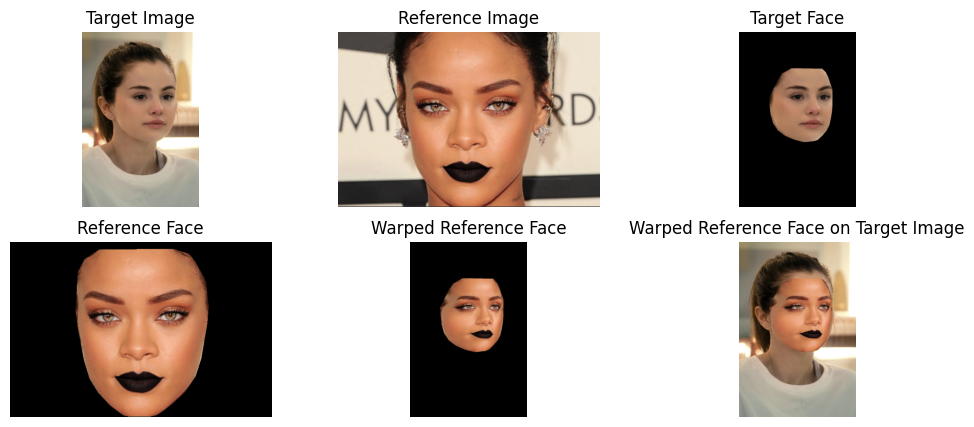

In [8]:
transform = PiecewiseAffineTransform()
transform.estimate(trgt_img_landmarks_np, ref_img_landmarks_np)

ref_face_hull = cv2.convexHull(ref_img_landmarks_np).astype(np.int32)
ref_face_mask = np.zeros(ref_img.shape[:2], dtype=np.float32)
cv2.fillConvexPoly(ref_face_mask, ref_face_hull, 1)
ref_face_mask = ref_face_mask > 0
ref_face = np.zeros_like(ref_img)
ref_face[ref_face_mask] = ref_img[ref_face_mask]

warped_ref_face = (warp(ref_img, transform, output_shape=trgt_img.shape) * 255).astype(np.uint8)

trgt_face_hull = cv2.convexHull(trgt_img_landmarks_np).astype(np.int32)
trgt_face_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
cv2.fillConvexPoly(trgt_face_mask, trgt_face_hull, 1)

mask = (warped_ref_face != 0).all(axis=2)
#mask = trgt_face_mask > 0

warped_ref_face_on_trgt = warped_ref_face * mask[:,:,None] + trgt_img * ~mask[:,:,None]
warped_ref_face_on_trgt = warped_ref_face_on_trgt.astype(np.uint8)

trgt_face = trgt_img * mask[:,:,None]

plt.figure(figsize=(12,5))
plt.subplot(231)
plt.imshow(cropBorders(trgt_img, th, tw, rh, rw))
plt.axis('off')
plt.title("Target Image")
plt.subplot(232)
plt.imshow(cropBorders(ref_img, rh, rw, th, tw))
plt.axis('off')
plt.title("Reference Image")
plt.subplot(233)
plt.imshow(cropBorders(trgt_face, th, tw, rh, rw))
plt.axis('off')
plt.title("Target Face")
plt.subplot(234)
plt.imshow(cropBorders(ref_face, rh, rw, th, tw))
plt.axis('off')
plt.title("Reference Face")
plt.subplot(235)
plt.imshow(warped_ref_face)
plt.axis('off')
plt.title("Warped Reference Face")
plt.subplot(236)
plt.imshow(cropBorders(warped_ref_face_on_trgt, th, tw, rh, rw))
plt.axis('off')
plt.title("Warped Reference Face on Target Image")
plt.show()



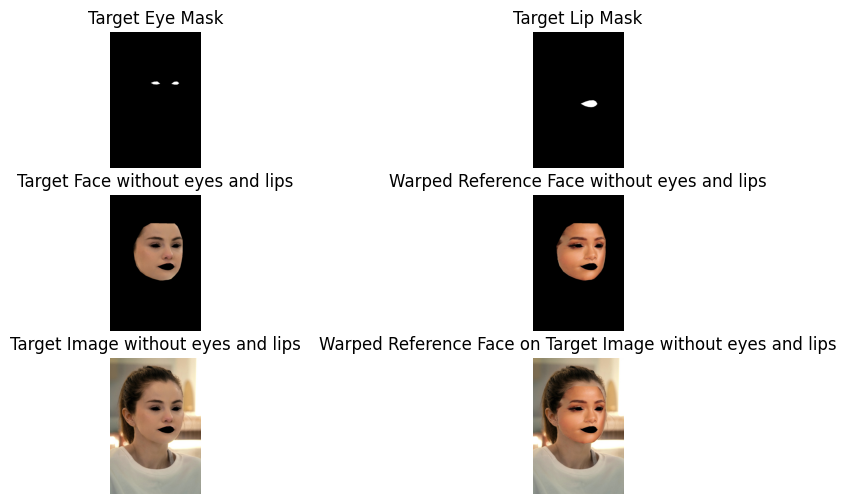

In [9]:
# remove eyes and lips from the target face by creating a mask of the eye region
trgt_left_eye = cv2.convexHull(np.array(trgt_img_landmarks[0]['left_eye']))
trgt_right_eye = cv2.convexHull(np.array(trgt_img_landmarks[0]['right_eye']))
trgt_top_lip = cv2.convexHull(np.array(trgt_img_landmarks[0]['top_lip']))
trgt_bottom_lip = cv2.convexHull(np.array(trgt_img_landmarks[0]['bottom_lip']))

trgt_left_eye_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
trgt_right_eye_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
trgt_top_lip_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
trgt_bottom_lip_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)

cv2.fillConvexPoly(trgt_left_eye_mask, trgt_left_eye, 1)
cv2.fillConvexPoly(trgt_right_eye_mask, trgt_right_eye, 1)
cv2.fillConvexPoly(trgt_top_lip_mask, trgt_top_lip, 1)
cv2.fillConvexPoly(trgt_bottom_lip_mask, trgt_bottom_lip, 1)

trgt_eye_mask = trgt_left_eye_mask + trgt_right_eye_mask
trgt_lip_mask = trgt_top_lip_mask + trgt_bottom_lip_mask
trgt_lip_mask[trgt_lip_mask > 1] = 1

# combine the masks
eye_lip_mask = trgt_eye_mask + trgt_lip_mask
eye_lip_mask[eye_lip_mask > 1] = 1

# remove the eyes and lips from the target face and the warped reference face
trgt_face_without_eye_lip = trgt_face * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)
warped_ref_face_without_eye_lip = warped_ref_face * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)

trgt_img_without_eye_lip = trgt_img * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)
warped_ref_face_on_trgt_without_eye_lip = warped_ref_face_on_trgt * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)

plt.figure(figsize=(10,6))
plt.subplot(321)
plt.imshow(trgt_eye_mask, cmap='gray')
plt.axis('off')
plt.title("Target Eye Mask")
plt.subplot(322)
plt.imshow(trgt_lip_mask, cmap='gray')
plt.axis('off')
plt.title("Target Lip Mask")
plt.subplot(323)
plt.imshow(trgt_face_without_eye_lip)
plt.axis('off')
plt.title("Target Face without eyes and lips")
plt.subplot(324)
plt.imshow(warped_ref_face_without_eye_lip)
plt.axis('off')
plt.title("Warped Reference Face without eyes and lips")
plt.subplot(325)
plt.imshow(cropBorders(trgt_img_without_eye_lip, th, tw, rh, rw))
plt.axis('off')
plt.title("Target Image without eyes and lips")
plt.subplot(326)
plt.imshow(cropBorders(warped_ref_face_on_trgt_without_eye_lip, th, tw, rh, rw))
plt.axis('off')
plt.title("Warped Reference Face on Target Image without eyes and lips")
plt.show()


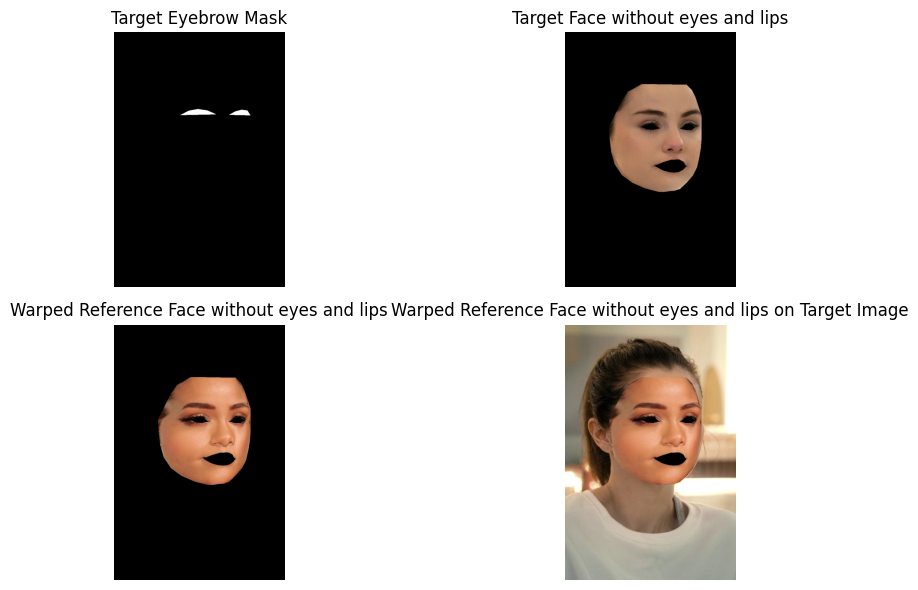

In [10]:
# remove eyebrows from the target face by creating a mask of the eyebrow region
trgt_left_eyebrow = cv2.convexHull(np.array(trgt_img_landmarks[0]['left_eyebrow']))
trgt_right_eyebrow = cv2.convexHull(np.array(trgt_img_landmarks[0]['right_eyebrow']))

trgt_left_eyebrow_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
trgt_right_eyebrow_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)

cv2.fillConvexPoly(trgt_left_eyebrow_mask, trgt_left_eyebrow, 1)
cv2.fillConvexPoly(trgt_right_eyebrow_mask, trgt_right_eyebrow, 1)

trgt_eyebrow_mask = trgt_left_eyebrow_mask + trgt_right_eyebrow_mask
trgt_eyebrow_mask[trgt_eyebrow_mask > 1] = 1

plt.figure(figsize=(12,6))
plt.subplot(221)
plt.imshow(trgt_eyebrow_mask, cmap='gray')
plt.axis('off')
plt.title("Target Eyebrow Mask")
plt.subplot(222)
plt.imshow(trgt_face_without_eye_lip)
plt.axis('off')
plt.title("Target Face without eyes and lips")
plt.subplot(223)
plt.imshow(cropBorders(warped_ref_face_without_eye_lip, th, tw, rh, rw))
plt.axis('off')
plt.title("Warped Reference Face without eyes and lips")
plt.subplot(224)
plt.imshow(cropBorders(warped_ref_face_on_trgt_without_eye_lip, th, tw, rh, rw))
plt.axis('off')
plt.title("Warped Reference Face without eyes and lips on Target Image")
plt.tight_layout()
plt.show()

### Linear Color Scaling of Reference Face to Match Target Face

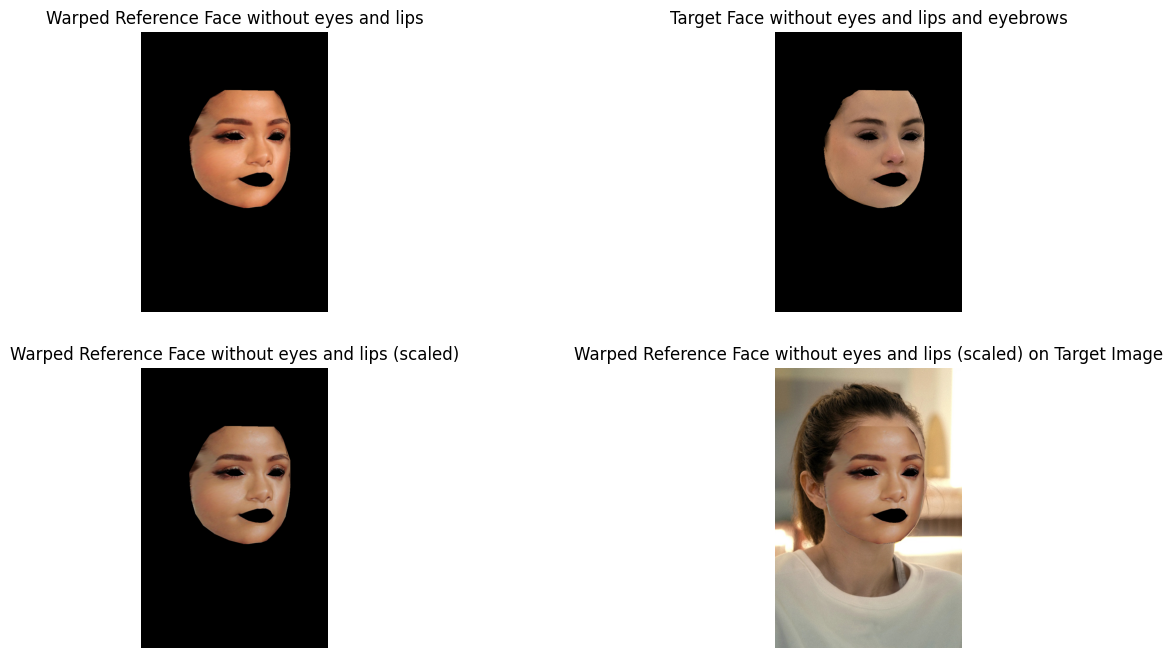

In [42]:
def linearColorScaling(warped_ref_face_without_eye_lip, trgt_face_without_eye_lip, face_mask):

    # scale the warped reference face to match the color of the target face. adjust the scaling factor to get the best result
    warped_ref_face_without_eye_lip_scaled = np.empty_like(warped_ref_face_without_eye_lip, dtype=np.float64)

    scaling_factors = np.linspace(0.6, 1.6, 200)

    for i in range(3):
        min_error = np.inf
        for scaling_factor in scaling_factors:
            a = warped_ref_face_without_eye_lip[:,:,i].flatten().astype(np.float64)
            b = trgt_face_without_eye_lip[:,:,i].flatten().astype(np.float64)
            a *= scaling_factor
            #a = np.clip(a, 0, 255)
            error = np.sum((a - b) ** 2)
            if error < min_error:
                min_error = error
                best_scaling_factor = scaling_factor
        
        warped_ref_face_without_eye_lip_scaled[:,:,i] = warped_ref_face_without_eye_lip[:,:,i].astype(np.float64) * best_scaling_factor
        warped_ref_face_without_eye_lip_scaled[:,:,i] = np.clip(warped_ref_face_without_eye_lip_scaled[:,:,i], 0, 255)

        #print("Scaling Factor for channel {} : {}".format(i, best_scaling_factor))

    warped_ref_face_without_eye_lip_scaled[~face_mask] = 0
    
    return warped_ref_face_without_eye_lip_scaled.astype(np.uint8)

face_mask = mask - eye_lip_mask
face_mask[face_mask < 0] = 0
face_mask = face_mask.astype(bool)

warped_ref_face_without_eye_lip_scaled = linearColorScaling(warped_ref_face_without_eye_lip, trgt_face_without_eye_lip, face_mask)

warped_ref_face_without_eye_lip_scaled_on_trgt = warped_ref_face_without_eye_lip_scaled * face_mask[:,:,None] + trgt_img_without_eye_lip * ~face_mask[:,:,None]

# show the original and scaled warped reference face
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.imshow(cropBorders(warped_ref_face_without_eye_lip, th, tw, rh, rw))
plt.axis('off')
plt.title("Warped Reference Face without eyes and lips")
plt.subplot(222)
plt.imshow(cropBorders(trgt_face_without_eye_lip, th, tw, rh, rw))
plt.axis('off')
plt.title("Target Face without eyes and lips and eyebrows")
plt.subplot(223)
plt.imshow(cropBorders(warped_ref_face_without_eye_lip_scaled, th, tw, rh, rw))
plt.axis('off')
plt.title("Warped Reference Face without eyes and lips (scaled)")
plt.subplot(224)
plt.imshow(cropBorders(warped_ref_face_without_eye_lip_scaled_on_trgt, th, tw, rh, rw))
plt.axis('off')
plt.title("Warped Reference Face without eyes and lips (scaled) on Target Image")
plt.show()


### Otsu's Method

In [12]:
def compute_otsu_criteria(img, th):
    """Otsu's method to compute criteria."""
    
    # create the thresholded image
    thresholded_channel = np.zeros(img.shape)
    thresholded_channel[img >= th] = 1
    # compute weights
    nb_pixels = img.size
    nb_pixels1 = np.count_nonzero(thresholded_channel)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    if weight1 == 0 or weight0 == 0:
        return np.inf
    # find all pixels belonging to each class
    val_pixels1 = img[thresholded_channel == 1]
    val_pixels0 = img[thresholded_channel == 0]
    # compute variance of these classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0
    return weight0 * var0 + weight1 * var1

def otsuThresholding(img):

    # testing all thresholds from 0 to the maximum of the image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    threshold_range = range(np.max(img) + 1)
    criterias = [compute_otsu_criteria(img, th) for th in threshold_range]
    # best threshold is the one minimizing the Otsu criteria
    best_threshold = threshold_range[np.argmin(criterias)]
    threshold_mask = img.copy()
    threshold_mask = threshold_mask.astype(np.uint8)
    threshold_mask[threshold_mask >= best_threshold] = 255
    threshold_mask[threshold_mask < best_threshold] = 0
    return threshold_mask.astype(bool)

img = trgt_face_without_eye_lip.copy()
threshold_mask = otsuThresholding(img)
img2 = warped_ref_face_without_eye_lip.copy()
threshold_mask2 = otsuThresholding(img2)


# otsu cuts off areas of low illumination, so it is not desirable in some cases
face_mask_eroded = cv2.erode(trgt_face_mask.astype(np.uint8), np.ones((11,11), np.uint8), iterations=1)
threshold_mask = threshold_mask * (1-face_mask_eroded.astype(bool)) + face_mask_eroded.astype(bool)
threshold_mask2 = threshold_mask2 * (1-face_mask_eroded.astype(bool)) + face_mask_eroded.astype(bool)


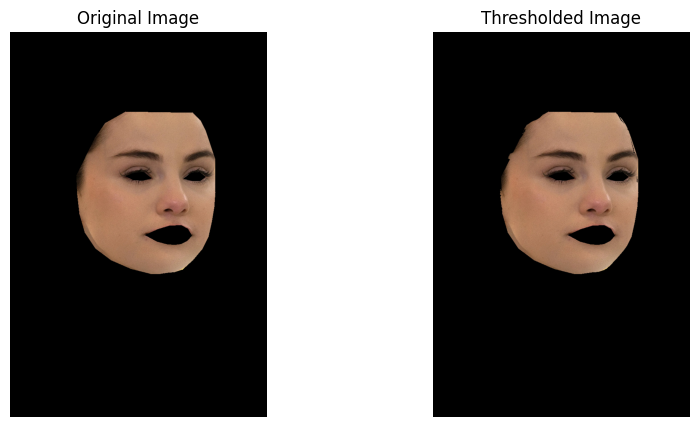

In [13]:
# show the results
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(trgt_face_without_eye_lip)
plt.axis('off')
plt.title("Original Image")
plt.subplot(122)
plt.imshow(trgt_face_without_eye_lip*threshold_mask[:,:,None]*threshold_mask2[:,:,None])
plt.axis('off')
plt.title("Thresholded Image")
plt.show()

trgt_face_without_eye_lip = trgt_face_without_eye_lip*threshold_mask[:,:,None]*threshold_mask2[:,:,None]
warped_ref_face_without_eye_lip_scaled = warped_ref_face_without_eye_lip_scaled*threshold_mask[:,:,None]*threshold_mask2[:,:,None]
face_mask = face_mask*threshold_mask*threshold_mask2

### Layer Decomposition

The face layers are converted to CIE Lab colour space. The Lightness (highlight) layer $L$ is given by,
$$
L = s + d
$$
where $s$ is the large scale layer and $d$ is the detail layer.
$s$ is obtained from $L$ by applying a Weighted Least Squares (WLS) filter. The detail layer $d$ is obtained by subtracting $s$ from $L$.

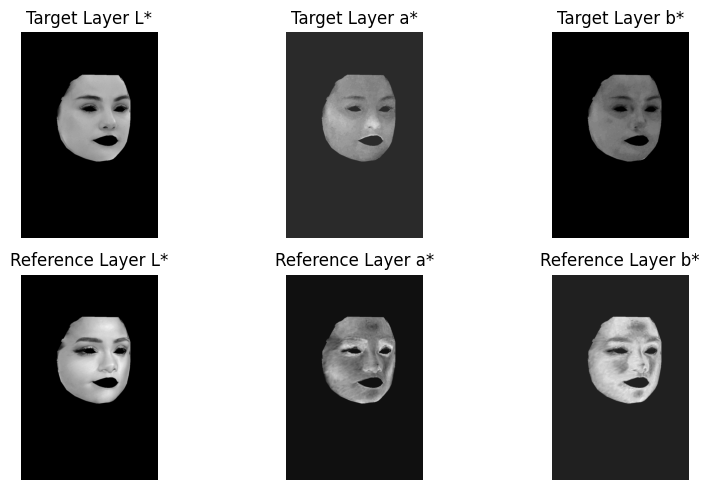

In [14]:
# renaming layers for better readability
trgt_layer = trgt_face_without_eye_lip.astype(np.uint8)
ref_layer = warped_ref_face_without_eye_lip_scaled.astype(np.uint8)

# convert to CIE L*a*b* colorspace
trgt_layer_lab = cv2.cvtColor(trgt_layer, cv2.COLOR_RGB2LAB)
ref_layer_lab = cv2.cvtColor(ref_layer, cv2.COLOR_RGB2LAB)

trgt_L = trgt_layer_lab[:,:,0]
ref_L = ref_layer_lab[:,:,0]

# show the layers in the CIE L*a*b* colorspace
plt.figure(figsize=(9,5))
plt.subplot(231)
plt.imshow(trgt_layer_lab[:,:,0], cmap='gray')
plt.axis('off')
plt.title("Target Layer L*")
plt.subplot(232)
plt.imshow(trgt_layer_lab[:,:,1], cmap='gray')
plt.axis('off')
plt.title("Target Layer a*")
plt.subplot(233)
plt.imshow(trgt_layer_lab[:,:,2], cmap='gray')
plt.axis('off')
plt.title("Target Layer b*")
plt.subplot(234)
plt.imshow(ref_layer_lab[:,:,0], cmap='gray')
plt.axis('off')
plt.title("Reference Layer L*")
plt.subplot(235)
plt.imshow(ref_layer_lab[:,:,1], cmap='gray')
plt.axis('off')
plt.title("Reference Layer a*")
plt.subplot(236)
plt.imshow(ref_layer_lab[:,:,2], cmap='gray')
plt.axis('off')
plt.title("Reference Layer b*")
plt.tight_layout()
plt.show()


In [15]:
import scipy.sparse as sparse
import scipy.sparse.linalg as sl

def process_difference_operator(difference_operator, lambda_, alpha, epsilon):
    difference_operator = -lambda_ / (epsilon + (np.absolute(difference_operator)**alpha))
    return difference_operator

def wlsFilter(L, lambda_=0.35, alpha=1.2, epsilon=1e-4):
    # Get log-luminance
    L_log = np.log(L.astype(np.float64) + 1e-10)

    # Compute the forward and backward differences of the luminance channel
    dx_forward = L_log - cv2.copyMakeBorder(L_log[:,1:], top=0, bottom=0, left=0, right=1, 
                                        borderType=cv2.BORDER_REPLICATE)
    dx_backward = L_log - cv2.copyMakeBorder(L_log[:,:-1], top=0, bottom=0, left=1, right=0,
                                        borderType=cv2.BORDER_REPLICATE)
    dy_forward = L_log - cv2.copyMakeBorder(L_log[1:,:], top=0, bottom=1, left=0, right=0,
                                        borderType=cv2.BORDER_REPLICATE)
    dy_backward = L_log - cv2.copyMakeBorder(L_log[:-1,:], top=1, bottom=0, left=0, right=0,
                                        borderType=cv2.BORDER_REPLICATE)

    # Weight each derivative
    dx_forward_weighted = process_difference_operator(dx_forward, lambda_, alpha, epsilon)
    dx_forward_weighted[:,-1] = 0

    dx_backward_weighted = process_difference_operator(dx_backward, lambda_, alpha, epsilon)
    dx_backward_weighted[:,0] = 0

    dy_forward_weighted = process_difference_operator(dy_forward, lambda_, alpha, epsilon)
    dy_forward_weighted[-1,:] = 0

    dy_backward_weighted = process_difference_operator(dy_backward, lambda_, alpha, epsilon)
    dy_backward_weighted[0,:] = 0

    central_element = np.ones_like(dx_forward)-(dx_forward_weighted + dx_backward_weighted +
                                   dy_forward_weighted + dy_backward_weighted)

    # Form sparse matrix
    N = L.size
    C = L.shape[1]

    row = np.zeros(5*N)
    col = np.zeros_like(row)
    data = np.zeros_like(row)

    # Central element
    row[:N] = np.arange(N)
    col[:N] = row[:N]
    data[:N] = central_element.ravel()

    # dx_forward
    row[N:2*N] = np.arange(N)
    col[N:2*N] = row[N:2*N] + 1
    data[N:2*N] = dx_forward_weighted.ravel()

    # dx_backward
    row[2*N:3*N] = np.arange(N)
    col[2*N:3*N] = row[2*N:3*N] - 1
    data[2*N:3*N] = dx_backward_weighted.ravel()

    #dy_forward
    row[3*N:4*N] = np.arange(N)
    col[3*N:4*N] = row[3*N:4*N] + C
    data[3*N:4*N] = dy_forward_weighted.ravel()

    #dy_backward
    row[4*N:5*N] = np.arange(N)
    col[4*N:5*N] = row[4*N:5*N] - C
    data[4*N:5*N] = dy_backward_weighted.ravel()

    row = row.astype(np.int32)
    col = col.astype(np.int32)

    data[col >= N] = 0
    data[col < 0] = 0
    row[col >= N] = 0
    row[col < 0] = 0
    col[col >= N] = 0
    col[col < 0] = 0

    A = sparse.coo_matrix((data, (row, col))).tocsr()
    b = L.ravel()

    s, info = sl.cg(A=A, b=b)
    s = s.reshape(L.shape)

    return s
    

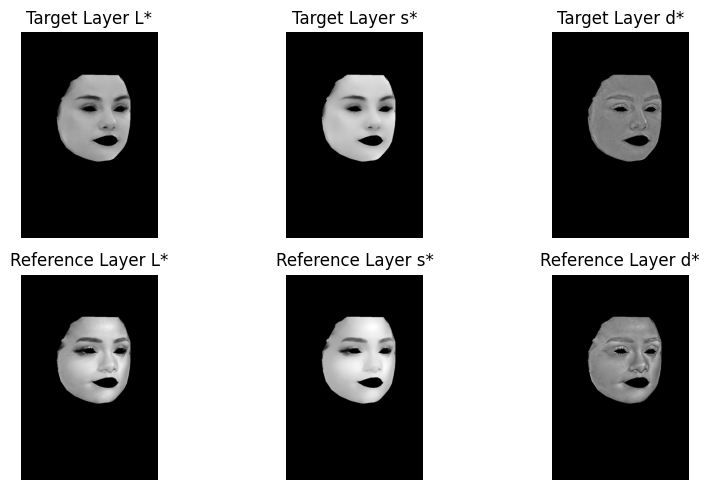

In [16]:

trgt_s = wlsFilter(trgt_L, lambda_=0.5, alpha=1.2, epsilon=1e-4)
ref_s = wlsFilter(ref_L, lambda_=0.5, alpha=1.2, epsilon=1e-4)

trgt_d = (trgt_L - trgt_s)
ref_d = (ref_L - ref_s)

trgt_d = cv2.normalize(trgt_d, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
ref_d = cv2.normalize(ref_d, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

face_mask = face_mask.astype(np.uint8)

trgt_d *= face_mask
ref_d *= face_mask

trgt_s = trgt_s.astype(np.uint8)
ref_s = ref_s.astype(np.uint8)

# show L, s and d layers
plt.figure(figsize=(9,5))
plt.subplot(231)
plt.imshow(trgt_L, cmap='gray')
plt.axis('off')
plt.title("Target Layer L*")
plt.subplot(232)
plt.imshow(trgt_s, cmap='gray')
plt.axis('off')
plt.title("Target Layer s*")
plt.subplot(233)
plt.imshow(trgt_d, cmap='gray')
plt.axis('off')
plt.title("Target Layer d*")
plt.subplot(234)
plt.imshow(ref_L, cmap='gray')
plt.axis('off')
plt.title("Reference Layer L*")
plt.subplot(235)
plt.imshow(ref_s, cmap='gray')
plt.axis('off')
plt.title("Reference Layer s*")
plt.subplot(236)
plt.imshow(ref_d, cmap='gray')
plt.axis('off')
plt.title("Reference Layer d*")
plt.tight_layout()
plt.show()



### Highlight Transfer/ Large Scale Layer Transfer

In [19]:
import scipy.sparse
from scipy.sparse.linalg import spsolve

def laplacian_matrix(n, m):

    mat_D = scipy.sparse.lil_matrix((m, m))
    mat_D.setdiag(-1, -1)
    mat_D.setdiag(4)
    mat_D.setdiag(-1, 1)
        
    mat_A = scipy.sparse.block_diag([mat_D] * n).tolil()
    
    mat_A.setdiag(-1, 1*m)
    mat_A.setdiag(-1, -1*m)
    
    return mat_A

def poisson_blend(source, target, mask):
  
    h, w = mask.shape
    y_range, x_range = h, w
    mask[mask > 0] = 1
    
    mat_A = laplacian_matrix(y_range, x_range)

    # for \Delta g
    laplacian = mat_A.tocsc()

    # set the region outside the mask to identity    
    for y in range(1, y_range - 1):
        for x in range(1, x_range - 1):
            if mask[y, x] == 0:
                k = x + y * x_range
                mat_A[k, k] = 1
                mat_A[k, k + 1] = 0
                mat_A[k, k - 1] = 0
                mat_A[k, k + x_range] = 0
                mat_A[k, k - x_range] = 0

    mat_A = mat_A.tocsc()

    mask_flat = mask.flatten()    
    source_flat = source.flatten()
    target_flat = target.flatten()        
   
    alpha = 1
    #print(laplacian.shape)
    #print(source_flat.shape)
    mat_b = laplacian.dot(source_flat)*alpha

    mat_b[mask_flat==0] = target_flat[mask_flat==0]
    
    x = spsolve(mat_A, mat_b)
    x = x.reshape((y_range, x_range))
    x[x > 255] = 255
    x[x < 0] = 0
    x = x.astype('uint8')

    return x


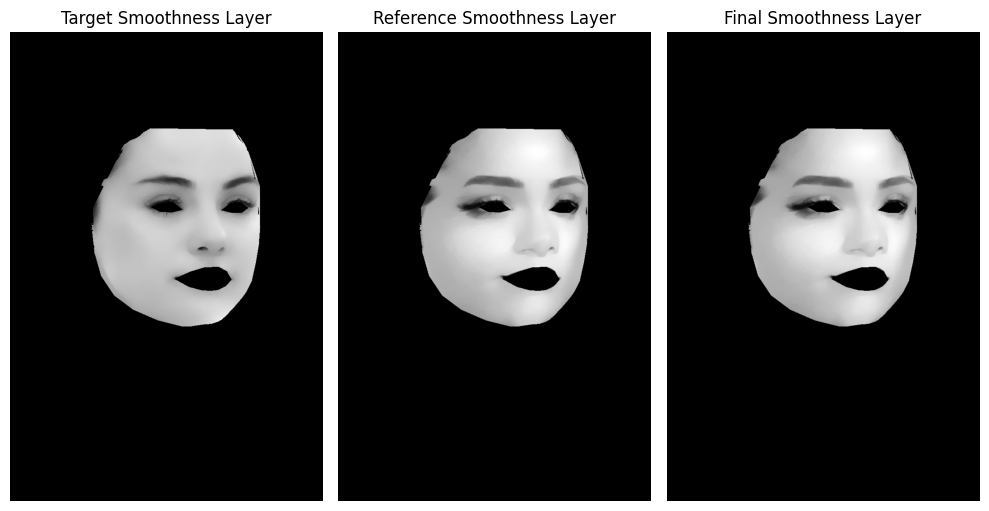

In [20]:
final_s = poisson_blend(ref_s, trgt_s, face_mask.astype(np.uint8))

plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(trgt_s, cmap='gray')
plt.axis('off')
plt.title("Target Smoothness Layer")
plt.subplot(132)
plt.imshow(ref_s, cmap='gray')
plt.axis('off')
plt.title("Reference Smoothness Layer")
plt.subplot(133)
plt.imshow(final_s, cmap='gray')
plt.axis('off')
plt.title("Final Smoothness Layer")
plt.tight_layout()
plt.show()

### Detail Transfer

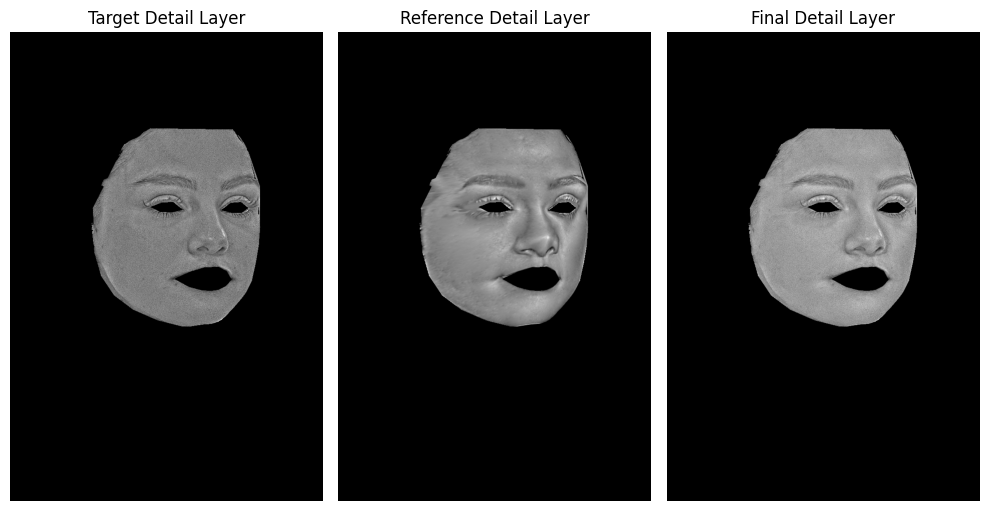

In [21]:
w_trgt = 1
w_ref = 0.5
final_d = (w_trgt * trgt_d + w_ref * ref_d)
final_d = cv2.normalize(final_d, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(trgt_d, cmap='gray')
plt.axis('off')
plt.title("Target Detail Layer")
plt.subplot(132)
plt.imshow(ref_d, cmap='gray')
plt.axis('off')
plt.title("Reference Detail Layer")
plt.subplot(133)
plt.imshow(final_d, cmap='gray')
plt.axis('off')
plt.title("Final Detail Layer")
plt.tight_layout()
plt.show()

### Colour Transfer

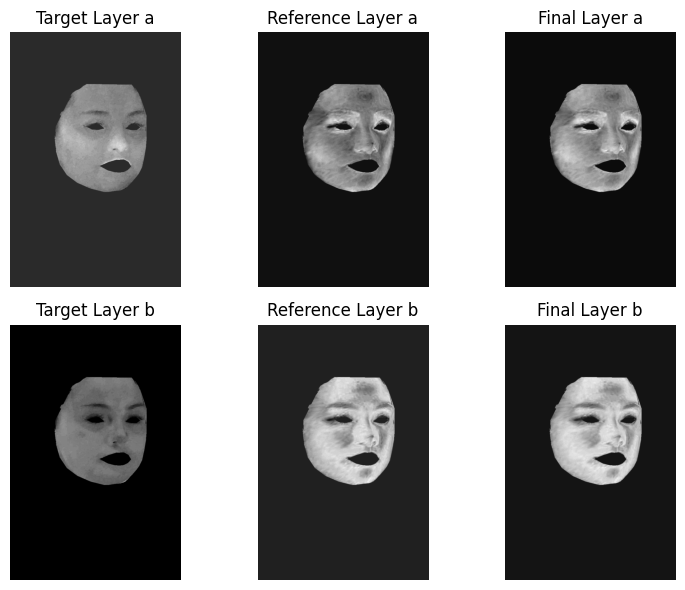

In [22]:
c = 0.8
final_a = trgt_layer_lab[:,:,1] * (1 - c) + ref_layer_lab[:,:,1] * c

final_b = trgt_layer_lab[:,:,2] * (1 - c) + ref_layer_lab[:,:,2] * c

plt.figure(figsize=(8,6))
plt.subplot(231)
plt.imshow(trgt_layer_lab[:,:,1], cmap='gray')
plt.axis('off')
plt.title("Target Layer a")
plt.subplot(232)
plt.imshow(ref_layer_lab[:,:,1], cmap='gray')
plt.axis('off')
plt.title("Reference Layer a")
plt.subplot(233)
plt.imshow(final_a, cmap='gray')
plt.axis('off')
plt.title("Final Layer a")
plt.subplot(234)
plt.imshow(trgt_layer_lab[:,:,2], cmap='gray')
plt.axis('off')
plt.title("Target Layer b")
plt.subplot(235)
plt.imshow(ref_layer_lab[:,:,2], cmap='gray')
plt.axis('off')
plt.title("Reference Layer b")
plt.subplot(236)
plt.imshow(final_b, cmap='gray')
plt.axis('off')
plt.title("Final Layer b")
plt.tight_layout()
plt.show()


### Combining the Layers

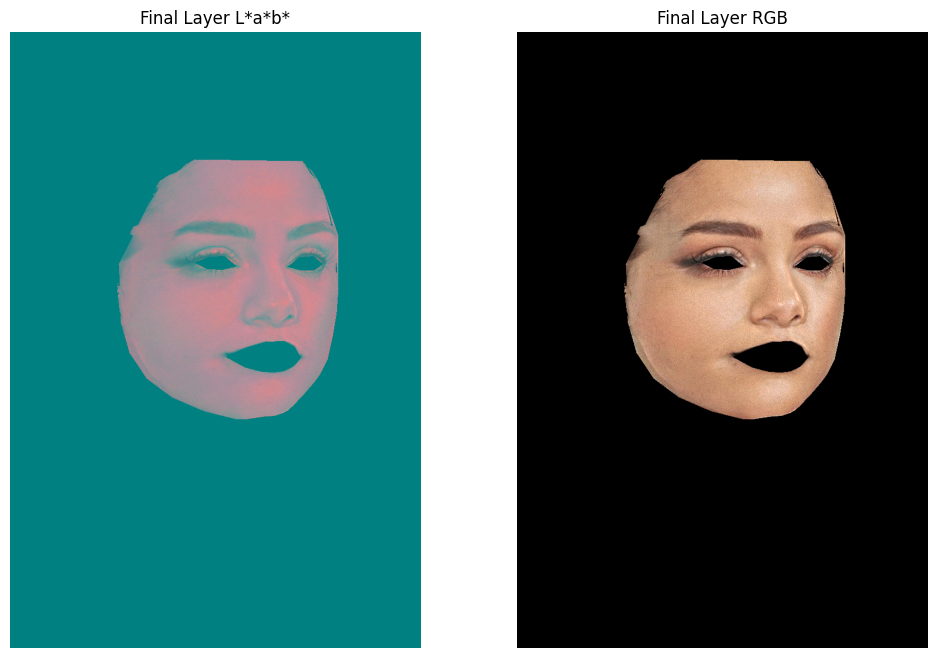

In [23]:
final_s = final_s.astype(np.float64)
final_d = final_d.astype(np.float64)
final_L = final_s + final_d

#final_L = cv2.normalize(final_L, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#final_L = 255 * (final_L - np.min(final_L)) / (np.max(final_L) - np.min(final_L))

# normalize such that minimum value is 0
# find the minimum value of the final layer in the face region

final_L[face_mask == 0] = np.inf
min_val = np.min(final_L)
final_L -= min_val
final_L[face_mask == 0] = 0
final_L = cv2.normalize(final_L, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

final_Lab = np.stack((final_L, final_a, final_b), axis=2)
final_Lab = final_Lab.astype(np.uint8)

final_RGB = cv2.cvtColor(final_Lab, cv2.COLOR_LAB2RGB)

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(final_Lab)
plt.axis('off')
plt.title("Final Layer L*a*b*")
plt.subplot(122)
plt.imshow(final_RGB)
plt.axis('off')
plt.title("Final Layer RGB")
plt.show()


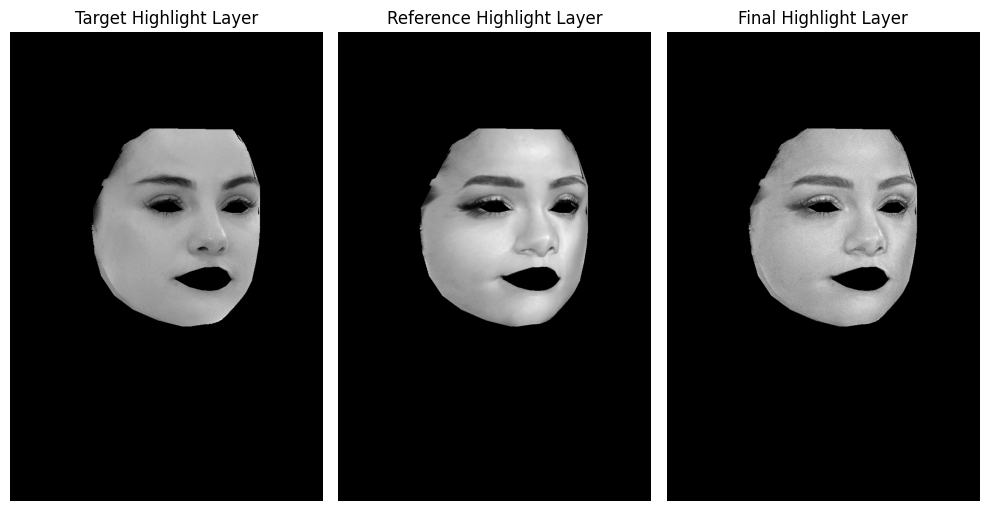

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(trgt_L, cmap='gray')
plt.axis('off')
plt.title("Target Highlight Layer")
plt.subplot(132)
plt.imshow(ref_L, cmap='gray')
plt.axis('off')
plt.title("Reference Highlight Layer")
plt.subplot(133)
plt.imshow(final_L, cmap='gray')
plt.axis('off')
plt.title("Final Highlight Layer")
plt.tight_layout()
plt.show()

### Blending Face and Background

In [25]:
# add lips and eyes back to the final rgb
final_RGB = final_RGB.astype(np.float64)
final_RGB += trgt_img * eye_lip_mask[:,:,None]

In [26]:
def calc_center(mask): 

    h, w = mask.shape
    top = 0
    bottom = h
    left = 0
    right = w

    for y in range(h):
        if np.sum(mask[y,:]) > 10:
            top = y
            break
    for y in range(h-1, -1, -1):
        if np.sum(mask[y,:]) > 10:
            bottom = y
            break
    for x in range(w):
        if np.sum(mask[:,x]) > 10:
            left = x
            break
    for x in range(w-1, -1, -1):
        if np.sum(mask[:,x]) > 10:
            right = x
            break

    return ((left + right) // 2, (top + bottom) // 2)

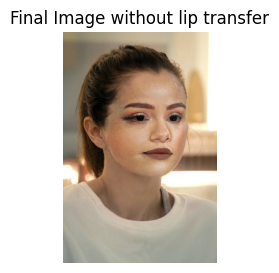

In [40]:

# blend using seamless cloning
final_RGB = final_RGB.astype(np.uint8)
#trgt_img = trgt_img.astype(np.uint8)
new_mask = face_mask + eye_lip_mask
new_mask[new_mask > 1] = 1
#trgt_img = trgt_img * (1-new_mask[:,:,None])
trgt_img = trgt_img.astype(np.uint8)

#m = cv2.moments(new_mask.astype(np.uint8))
#center = (int(m["m10"] / m["m00"]), int(m["m01"] / m["m00"]))
center = calc_center(new_mask) 
final_img = cv2.seamlessClone(final_RGB, trgt_img, (new_mask * 255).astype(np.uint8), center, cv2.NORMAL_CLONE)

plt.figure(figsize=(4,3))
plt.imshow(cropBorders(final_img, th, tw, rh, rw))
plt.axis('off')
plt.title("Final Image without lip transfer")
plt.show()

# Lip Transfer

In [28]:
trgt_lip = trgt_img * trgt_lip_mask[:,:,None]
trgt_lip = trgt_lip.astype(np.uint8)

warped_ref_lip = warped_ref_face * trgt_lip_mask[:,:,None]
warped_ref_lip = warped_ref_lip.astype(np.uint8)

trgt_lip_Lab = cv2.cvtColor(trgt_lip, cv2.COLOR_RGB2LAB)
warped_ref_lip_Lab = cv2.cvtColor(warped_ref_lip, cv2.COLOR_RGB2LAB)

trgt_lip_s = wlsFilter(trgt_lip_Lab[:,:,0], lambda_=0.5, alpha=1.2, epsilon=1e-4)
trgt_lip_d = (trgt_lip_Lab[:,:,0] - trgt_lip_s)
trgt_lip_d = cv2.normalize(trgt_lip_d, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

warped_ref_lip_s = wlsFilter(warped_ref_lip_Lab[:,:,0], lambda_=0.8, alpha=1.2, epsilon=1e-4)
warped_ref_lip_d = (warped_ref_lip_Lab[:,:,0] - warped_ref_lip_s)
warped_ref_lip_d = cv2.normalize(warped_ref_lip_d, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

trgt_lip_s = trgt_lip_s.astype(np.uint8)
trgt_lip_d = trgt_lip_d.astype(np.uint8)
warped_ref_lip_s = warped_ref_lip_s.astype(np.uint8)
warped_ref_lip_d = warped_ref_lip_d.astype(np.uint8)

la = 0.8
final_lip_s = trgt_lip_s
final_lip_s = trgt_lip_s * (1 - la) + warped_ref_lip_s * la

w_trgt = 0.5
w_ref = 1
final_lip_d = (trgt_lip_d * w_trgt + warped_ref_lip_d * w_ref)
final_lip_d = cv2.normalize(final_lip_d, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

final_lip_s = final_lip_s.astype(np.float64)
final_lip_d = final_lip_d.astype(np.float64)
final_lip_L = final_lip_s + final_lip_d

final_lip_L[~(trgt_lip_mask).astype(bool)] = np.inf
min_val = np.min(final_lip_L)
final_lip_L -= min_val
final_lip_L[~(trgt_lip_mask).astype(bool)] = 0
final_lip_L = cv2.normalize(final_lip_L, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

c = 0.8
final_lip_a = trgt_lip_Lab[:,:,1] * (1 - c) + warped_ref_lip_Lab[:,:,1] * c
final_lip_b = trgt_lip_Lab[:,:,2] * (1 - c) + warped_ref_lip_Lab[:,:,2] * c

final_lip_Lab = np.stack((final_lip_L, final_lip_a, final_lip_b), axis=2)
final_lip_Lab = final_lip_Lab.astype(np.uint8)

final_lip_RGB = cv2.cvtColor(final_lip_Lab, cv2.COLOR_LAB2RGB)

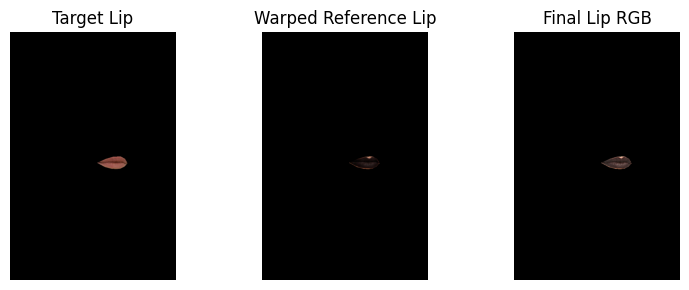

In [29]:
plt.figure(figsize=(8,3))
plt.subplot(131)
plt.imshow(trgt_lip)
plt.axis('off')
plt.title("Target Lip")
plt.subplot(132)
plt.imshow(warped_ref_lip)
plt.axis('off')
plt.title("Warped Reference Lip")
plt.subplot(133)
plt.imshow(final_lip_RGB)
plt.axis('off')
plt.title("Final Lip RGB")
plt.tight_layout()
plt.show()

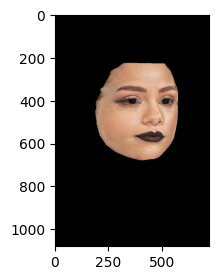

In [30]:
final_RGB_with_lip = final_RGB * (1 - trgt_lip_mask[:,:,None]) + final_lip_RGB * trgt_lip_mask[:,:,None]
final_RGB_with_lip = final_RGB_with_lip.astype(np.uint8)
plt.figure(figsize=(4,3))
plt.imshow(final_RGB_with_lip)

### Final Result

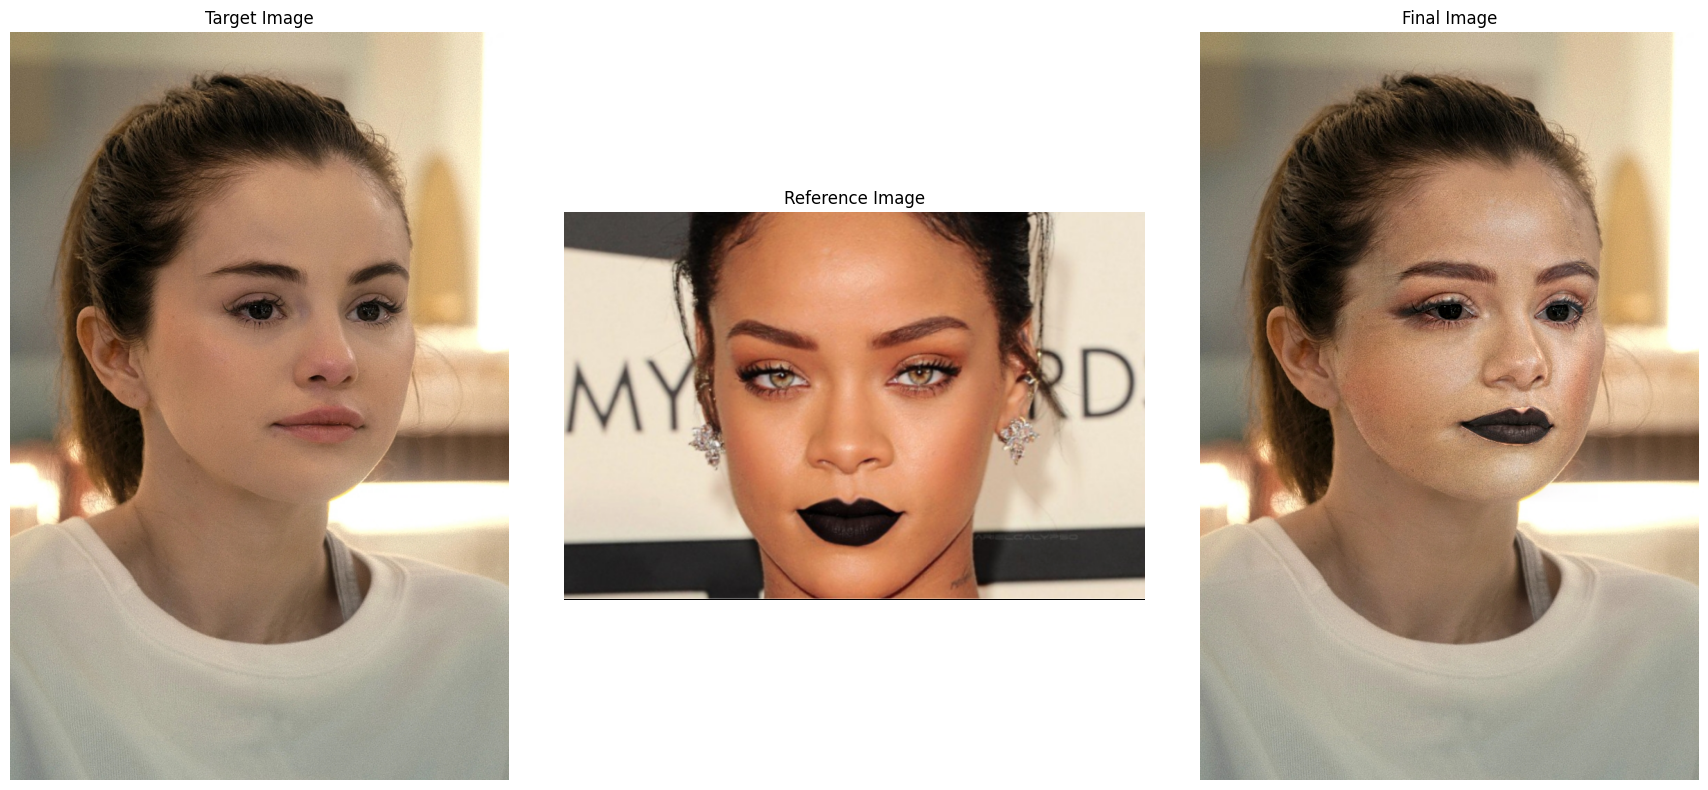

In [31]:
# add final rgb layer to the target image
trgt_img = trgt_img.astype(np.uint8)

#m = cv2.moments(new_mask.astype(np.uint8))
#center = (int(m["m10"] / m["m00"]), int(m["m01"] / m["m00"]) + 15)
center = calc_center(new_mask)
final_img = cv2.seamlessClone(final_RGB_with_lip, trgt_img, (new_mask * 255).astype(np.uint8), center, cv2.NORMAL_CLONE)


plt.figure(figsize=(18,8))
plt.subplot(131)
plt.imshow(cropBorders(trgt_img, th, tw, rh, rw))
plt.axis('off')
plt.title("Target Image")
plt.subplot(132)
plt.imshow(cropBorders(ref_img, rh, rw, th, tw))
plt.axis('off')
plt.title("Reference Image")
plt.subplot(133)
plt.imshow(cropBorders(final_img, th, tw, rh, rw))
plt.axis('off')
plt.title("Final Image")
plt.tight_layout()
plt.show()

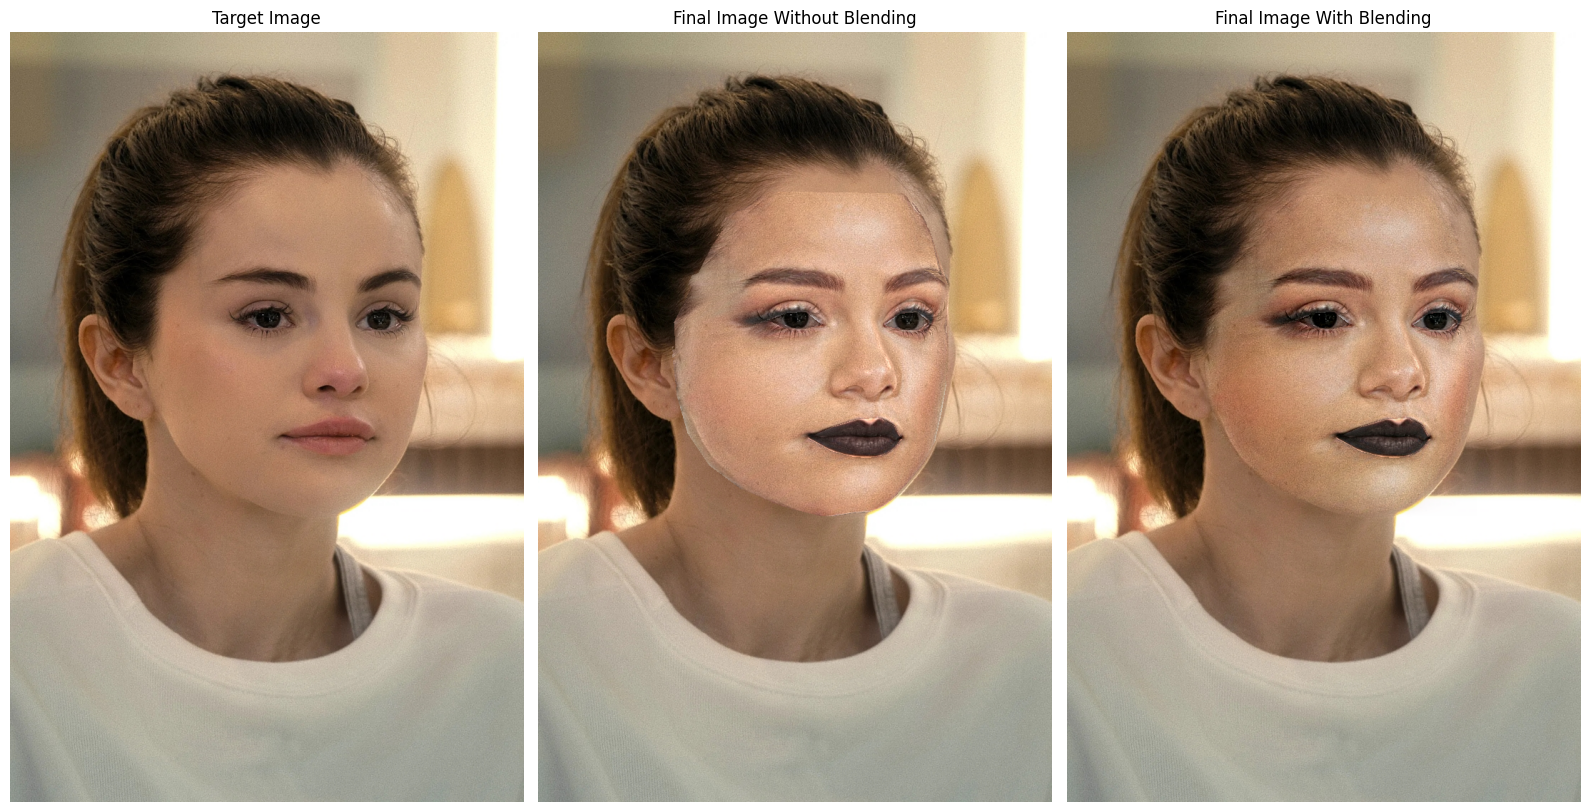

In [32]:
final_rgb_on_trgt = trgt_img * (1 - new_mask[:,:,None]) + final_RGB_with_lip * new_mask[:,:,None]
final_rgb_on_trgt = final_rgb_on_trgt.astype(np.uint8)
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(cropBorders(trgt_img, th, tw, rh, rw))
plt.axis('off')
plt.title("Target Image")
plt.subplot(132)
plt.imshow(cropBorders(final_rgb_on_trgt, th, tw, rh, rw))
plt.axis('off')
plt.title("Final Image Without Blending")
plt.subplot(133)
plt.imshow(cropBorders(final_img, th, tw, rh, rw))
plt.axis('off')
plt.title("Final Image With Blending")
plt.tight_layout()
plt.show()


## Custom Lip Shade

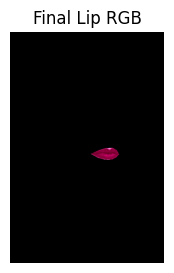

In [34]:
# define a lip shade in rgb
lip_shade = np.zeros_like(trgt_lip)
lip_shade[:, :, 0] = 255
lip_shade[:, :, 1] = 20
lip_shade[:, :, 2] = 147

# apply lip mask
lip_shade = lip_shade * trgt_lip_mask[:,:,None]
lip_shade_lab = cv2.cvtColor(lip_shade, cv2.COLOR_RGB2LAB)

c = 0.9
custom_lip_a = trgt_lip_Lab[:,:,1] * (1 - c) + lip_shade_lab[:,:,1] * c
custom_lip_b = trgt_lip_Lab[:,:,2] * (1 - c) + lip_shade_lab[:,:,2] * c

custom_lip_Lab = np.stack((final_lip_L, custom_lip_a, custom_lip_b), axis=2)
custom_lip_Lab = custom_lip_Lab.astype(np.uint8)

custom_lip_RGB = cv2.cvtColor(custom_lip_Lab, cv2.COLOR_LAB2RGB)
custom_lip_RGB = custom_lip_RGB.astype(np.uint8)

plt.figure(figsize=(4,3))
plt.imshow(custom_lip_RGB)
plt.axis('off')
plt.title("Final Lip RGB")
plt.show()

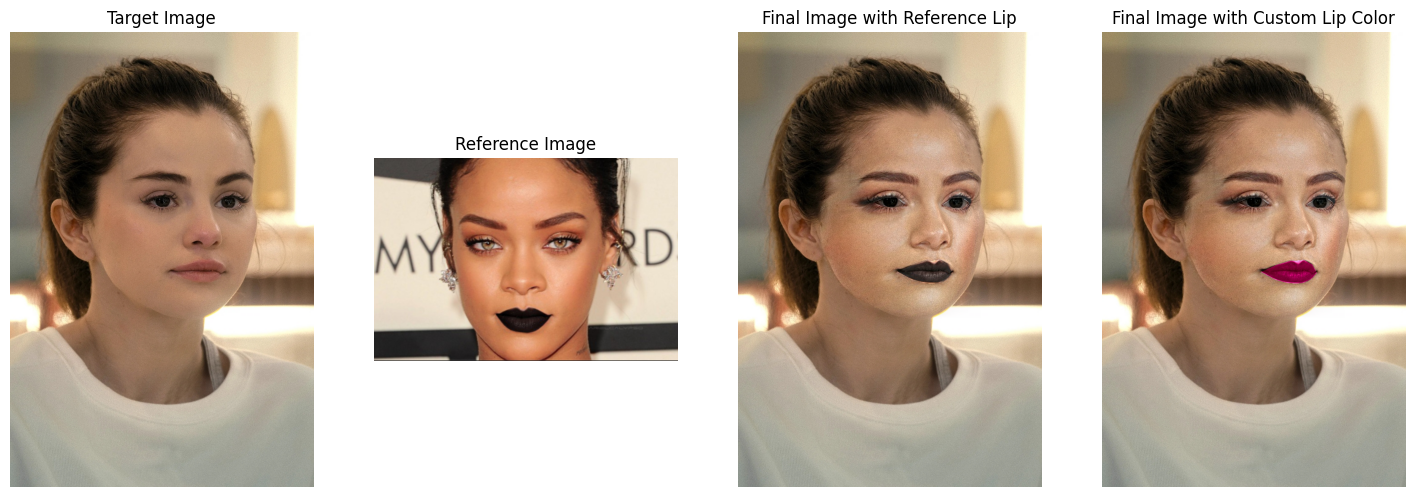

In [35]:
final_RGB_with_custom_lip = final_RGB * (1 - trgt_lip_mask[:,:,None]) + custom_lip_RGB * trgt_lip_mask[:,:,None]
final_RGB_with_custom_lip = final_RGB_with_custom_lip.astype(np.uint8)
center = calc_center(new_mask)
final_img_custom_lip = cv2.seamlessClone(final_RGB_with_custom_lip, trgt_img, (new_mask * 255).astype(np.uint8), center, cv2.NORMAL_CLONE)

plt.figure(figsize=(18,8))
plt.subplot(141)
plt.imshow(cropBorders(trgt_img, th, tw, rh, rw))
plt.axis('off')
plt.title("Target Image")
plt.subplot(142)
plt.imshow(cropBorders(ref_img, rh, rw, th, tw))
plt.axis('off')
plt.title("Reference Image")
plt.subplot(143)
plt.imshow(cropBorders(final_img, th, tw, rh, rw))
plt.axis('off')
plt.title("Final Image with Reference Lip")
plt.subplot(144)
plt.imshow(cropBorders(final_img_custom_lip, th, tw, rh, rw))
plt.axis('off')
plt.title("Final Image with Custom Lip Color")
plt.show()

## Circular Masking Test

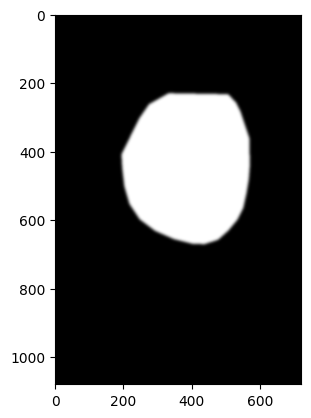

In [39]:
face_mask_new = trgt_face_mask.copy()
#face_mask_new = cv2.cvtColor(face_mask_new, cv2.COLOR_RGB2GRAY)
#face_mask_new[face_mask_new > 0] = 1
face_mask_new = cv2.erode(face_mask_new.astype(np.uint8), np.ones((17,17), np.uint8), iterations=1)
fmg = cv2.GaussianBlur(face_mask_new.astype(np.float64), (25,25), 0)
plt.imshow(fmg, cmap='gray')

fmg_not = 1-fmg
#plt.imshow((final_RGB_with_lip * fmg[:,:,None]).astype(np.uint8))

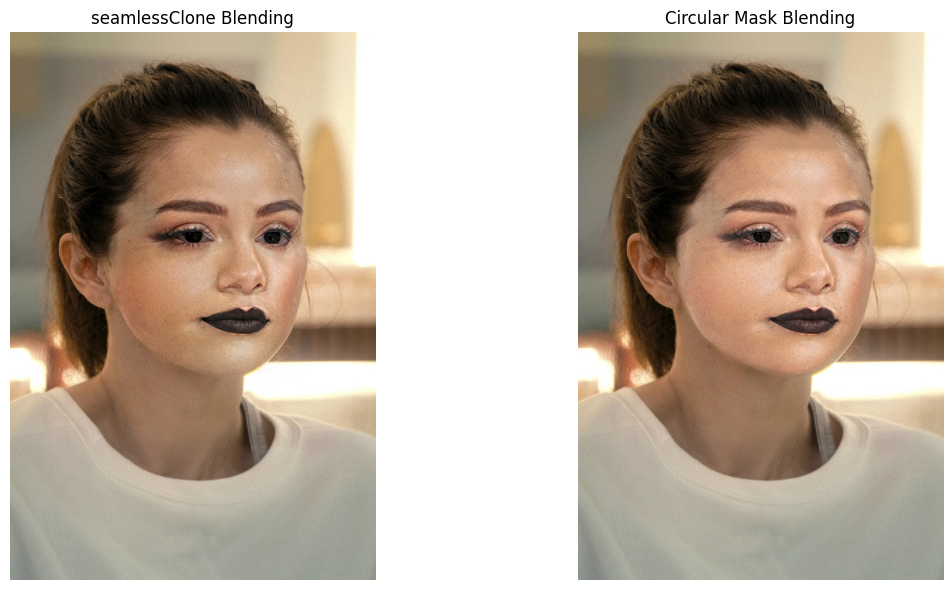

In [38]:
trgt_img_blur = trgt_img * fmg_not[:,:,None]
trgt_img_blur = trgt_img_blur.astype(np.uint8)
final_RGB_with_lip_blur = final_RGB_with_lip * fmg[:,:,None]
final_RGB_with_lip_blur = final_RGB_with_lip_blur.astype(np.uint8)
x = trgt_img_blur + final_RGB_with_lip_blur
x[x > 255] = 255

plt.figure(figsize=(13,6))
plt.subplot(121)
plt.imshow(cropBorders(final_img, th, tw, rh, rw))
plt.axis('off')
plt.title("seamlessClone Blending")
plt.subplot(122)
plt.imshow(cropBorders(x, th, tw, rh, rw))
plt.axis('off')
plt.title("Circular Mask Blending")
plt.tight_layout()
plt.show()